In [1]:

import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, save
from sklearn.model_selection import RandomizedSearchCV
# import load_data
# import exponential_modeling
# import fit_and_predict
# import copy

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [202]:
import numpy.random as npr
import numpy.linalg as npl


In [203]:
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')


In [204]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
                 names = [
        'date', 'state', 'region_code', 'region_name', 'lat',
       'long', 'hospitalized_with_symptoms', 'intensive_care',
       'total_hospitalized', 'home_isolation', 'total_positive',
       'total_positive_change', 'new_positives', 'discharged_healed',
       'total_deaths', 'total_cases', 'swabs', 'note_it', 'note_en'])

In [205]:
df = df.drop([0]) # drop the italian keys row
df.head()

,date,state,region_code,region_name,lat,long,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_isolation,total_positive,total_positive_change,new_positives,discharged_healed,total_deaths,total_cases,swabs,note_it,note_en
1,2020-02-24T18:00:00,ITA,13,Abruzzo,42.35122196,13.39843823,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN
2,2020-02-24T18:00:00,ITA,17,Basilicata,40.63947052,15.80514834,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
3,2020-02-24T18:00:00,ITA,04,P.A. Bolzano,46.49933453,11.35662422,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
4,2020-02-24T18:00:00,ITA,18,Calabria,38.90597598,16.59440194,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
5,2020-02-24T18:00:00,ITA,15,Campania,40.83956555,14.25084984,0,0,0,0,0,0,0,0,0,0,10,NaN,NaN


In [206]:
df = df[df.region_name !='P.A. Bolzano'] 

In [207]:
pop_df = pd.read_csv('italy_data.txt', delimiter='\t')

In [208]:
len(df)

880

In [209]:
df = pd.merge(df, pop_df, how='outer', on='region_name')

In [210]:
len(df)

880

In [211]:
df.region_name.unique(),df.region_name.nunique()

(array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
        'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
        'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana',
        'P.A. Trento', 'Umbria', "Valle d'Aosta", 'Veneto'], dtype=object), 20)

In [212]:
for key in [
        'region_code',  'lat',
       'long', 'hospitalized_with_symptoms', 'intensive_care',
       'total_hospitalized', 'home_isolation', 'total_positive',
       'total_positive_change', 'new_positives', 'discharged_healed',
       'total_deaths', 'total_cases', 'swabs']:
    df[key] = df[key].astype(float)


In [213]:
df.describe()


,region_code,lat,long,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_isolation,total_positive,total_positive_change,new_positives,discharged_healed,total_deaths,total_cases,swabs,2018_death_rate,2018_deaths,2018_population
count,880.00000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,8.800000e+02
mean,10.50000,42.873641,12.269422,674.570455,100.781818,775.352273,980.205682,1755.557955,105.164773,152.007955,329.153409,251.911364,2336.622727,11529.621591,10.900000,31656.650000,3.017977e+06
std,5.76956,2.425785,2.718865,1771.689573,213.700443,1981.863902,2135.828690,4023.894912,213.420443,330.852192,1493.859255,987.826695,6362.778440,23485.755208,1.265235,24551.564001,2.472345e+06
min,1.00000,38.115697,7.320149,0.000000,0.000000,0.000000,0.000000,0.000000,-386.000000,-17.000000,0.000000,0.000000,0.000000,0.000000,8.800000,1477.000000,1.256660e+05
25%,5.75000,41.054088,10.638510,8.000000,2.000000,10.000000,12.000000,22.750000,2.000000,4.000000,0.000000,0.000000,25.750000,357.750000,9.900000,13376.500000,1.179484e+06
50%,10.50000,43.361759,12.435957,92.000000,22.000000,116.000000,182.000000,345.500000,31.500000,41.000000,7.000000,11.000000,360.000000,2581.500000,11.150000,20997.000000,1.793361e+06
75%,15.25000,45.163682,13.888815,503.000000,101.500000,611.250000,826.750000,1420.500000,109.500000,138.250000,88.000000,109.000000,1718.750000,11375.500000,11.650000,50354.000000,4.571071e+06
max,20.00000,46.068935,16.867367,12009.000000,1381.000000,13328.000000,15212.000000,28469.000000,1950.000000,3251.000000,14498.000000,9484.000000,52325.000000,159331.000000,14.300000,99542.000000,1.006057e+07


In [214]:
from scipy.stats import norm as normal
from scipy.stats import laplace as laplace
from scipy.optimize import curve_fit

In [215]:
npr.seed(12)
n = 100
xx = np.linspace(0, 3, n)
y = model_gauss(xx, 2., 3., 0.) + 0.2* npr.randn(n)

In [216]:
def log_model_gauss(t, p, a, b):
    return(np.log(model_gauss(t, p, a, b)))

In [217]:
def model_laplace(t, p, a, b):
    return(p*laplace.cdf(a*(t-b)))
def model_gauss(t, p, a, b):
    return(p*normal.cdf(a*(t-b)))

In [ ]:
## Death peak vs cases peak

## FIrst comparison between Lplace and Gauss

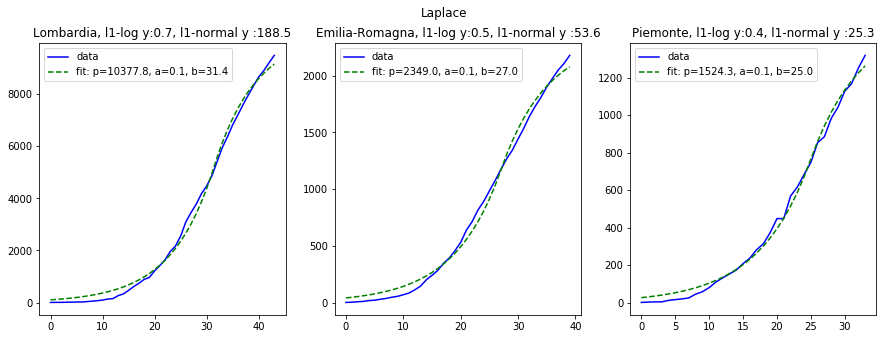

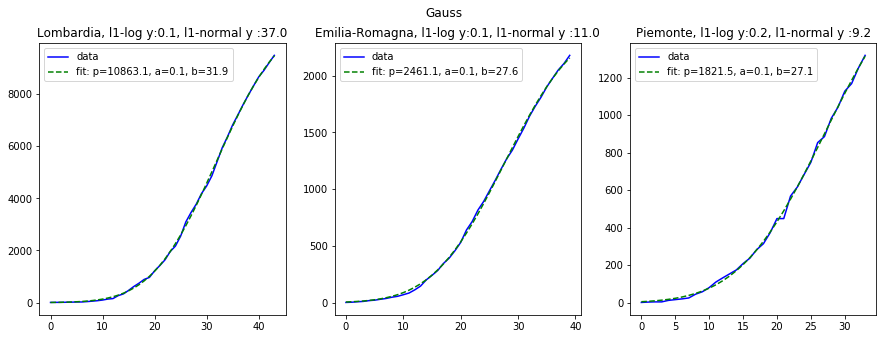

In [218]:
dfg = df.groupby('region_name')

for model, label in  zip([model_laplace, model_gauss], ['Laplace', 'Gauss']):
    plt.figure(figsize=[15, 5])
    for j, grp in enumerate(['Lombardia', 'Emilia-Romagna', 'Piemonte']):
        group = dfg.get_group(grp).reset_index()
        group["death_rate"] = group["total_deaths"] / group['2018_population']
        y = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values
        x = np.arange(len(y))
        popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
        y_fit =  model(x, *popt)
        plt.subplot(1, 3, j+1)
        plt.plot(x, y, 'b-', label='data')
        plt.plot(x, y_fit, 'g--',label='fit: p=%.1f, a=%.1f, b=%.1f' % tuple(popt))
        l1_error_log_y = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
        l1_error = np.mean(np.abs(y-y_fit))
        plt.legend()
        plt.title('%s, l1-log y:%.1f, l1-normal y :%.1f'%(grp, l1_error_log_y, l1_error))
    plt.suptitle(label)
    plt.show()

## Comparing Perturbation effects on the fit (on a subset of data)

### Odd/Even data : its okay as long as long as there are enough data points

Abruzzo Lap 1566.9666903497327 0.1325676084420268 36.15565867485141
Abruzzo Lap 1587.4740318848762 0.14154157482684215 35.09130523751102
Basilicata Lap 4344.952690867258 0.22605053830075048 33.703759630345125
Basilicata Lap 3558.8138625712395 0.2187190907303065 33.96549148067778
Emilia-Romagna Lap 2060.499734652668 0.13675748051139366 25.453108323123466
Emilia-Romagna Lap 2132.978091698956 0.1324840337021286 25.817865202580162


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Toscana Lap 1864.016678883211 0.11023735903913272 31.695558170979755
Toscana Lap 1869.842413627784 0.11467241239795133 30.933424526604792
Veneto Lap 698.9723399132188 0.135281416797949 30.69219193374293
Veneto Lap 716.3988609447914 0.13283252485719713 31.005080369584018


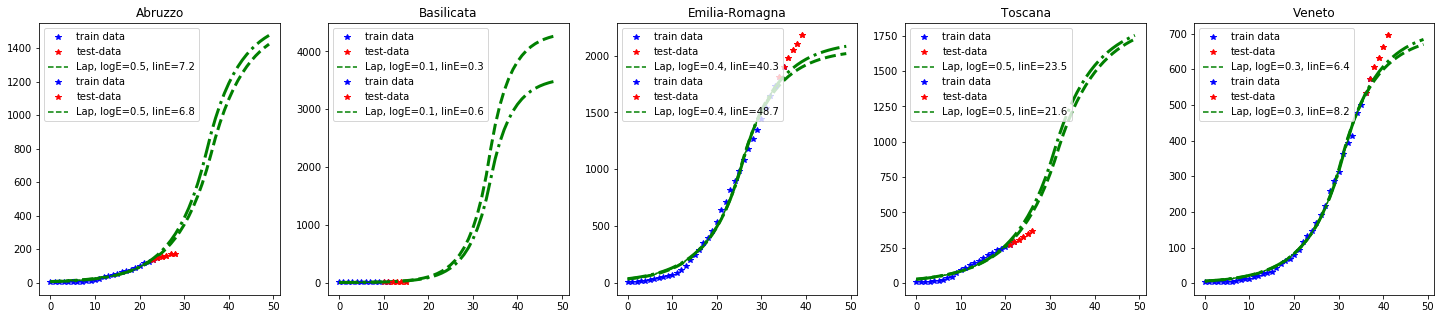

Abruzzo Gauss 209.7736136946622 0.131725141757374 20.248045016451826
Abruzzo Gauss 194.62188887340974 0.14086436708858868 19.58453283775794
Basilicata Gauss 38.39545356109226 0.14299006353830673 14.466380600415075
Basilicata Gauss 14.212598003999119 0.2710411283965783 8.075877990260546
Emilia-Romagna Gauss 2301.123096317443 0.10782857152869747 26.763124686703936
Emilia-Romagna Gauss 2352.661429374769 0.10553549207517847 27.020723799048135
Toscana Gauss 306.4192773678238 0.16671132125760976 13.67183435088179
Toscana Gauss 290.62640397337924 0.17351856281181977 13.18377965153532
Veneto Gauss 1122.6118757401828 0.08807319667387069 36.502417494732725
Veneto Gauss 1121.6093045404 0.08705265266591793 36.66161304962613


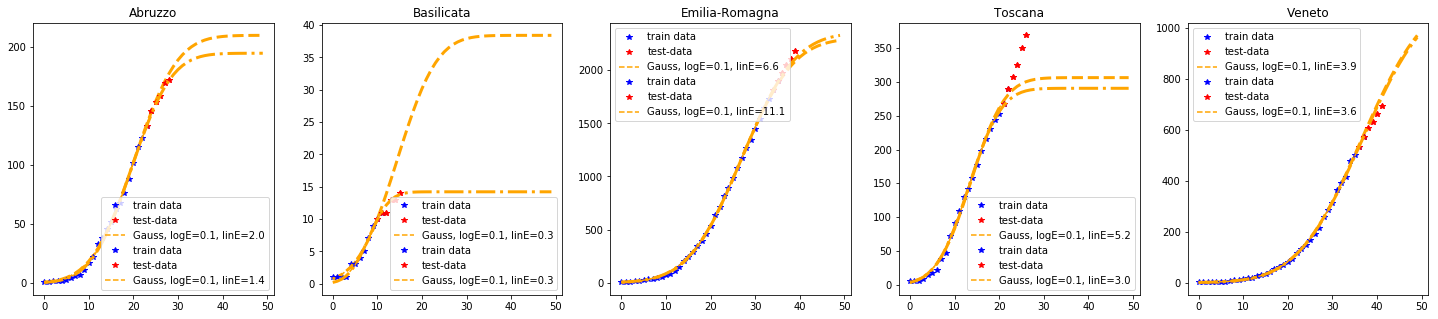

In [274]:
grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
errors = np.zeros((2, len(grp_names)))
log_errors =  np.zeros((2, len(grp_names)))
lap_params =  np.zeros((len(grp_names), 3))
gauss_params =  np.zeros((len(grp_names), 3))

test_offset = -4
i = 0

for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
    plt.figure(figsize=[25, 5])
    for j, grp in enumerate(grp_names):
        for start, lss in zip([0, 1], ['--', '-.']):
            group = dfg.get_group(grp).reset_index()
            group["death_rate"] = group["total_deaths"] / group['2018_population']
            yvec = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values
            x = np.arange(start, len(yvec)+test_offset, 2)
            y = yvec[x]

            y_test = yvec[max(x):]
            x_test = np.arange(max(x), len(yvec))

            plt.subplot(1, 5, j+1)
            plt.plot(x, y, 'b*', label='train data')
            plt.plot(x_test, y_test, 'r*', label='test-data')
            if len(y) > 4:
                popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
                y_fit =  model(x, *popt)
                log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
                errors[i, j] = np.mean(np.abs(y-y_fit))
                params[j, :] = np.asarray(popt)
                plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
                plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3.)
                print(grp, label, *popt)
            plt.legend()
            plt.title(grp)
        # plt.suptitle(label)
    plt.show()
    i += 1

### Stability to number of data points: If early in the stage, too unstable

Abruzzo Lap 1303.4706963079577 0.1123691984885926 37.902747906663116
Abruzzo Lap 1558.3581981557538 0.1355621186805848 35.705782568083464
Abruzzo Lap 1739.3720857810968 0.15207339580185328 34.29673318037145
Basilicata Lap 2532.556725764055 0.1500156776307658 43.588210560730246
Basilicata Lap 3834.136089101079 0.21727653289391688 34.33634834478884
Basilicata Lap 5057.558256938837 0.2804112322430075 29.075923160414437


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Emilia-Romagna Lap 2297.6011894155163 0.12531422536152875 26.756359712718705
Emilia-Romagna Lap 2103.125661431692 0.13409498779688667 25.67101729918718
Emilia-Romagna Lap 1941.9789132452847 0.14179727178060958 24.774477869413904
Toscana Lap 1578.8847903937776 0.09549070720649673 32.52565624050472
Toscana Lap 1840.8482134826713 0.11070834221160492 31.40007637742341
Toscana Lap 2079.421827507009 0.12619784449279906 30.098131440076255
Veneto Lap 780.4519158008937 0.127778854113576 31.89817105274412
Veneto Lap 709.3198269290608 0.13383395701833356 30.874313286513264
Veneto Lap 1096.2171526975596 0.11949935211261487 35.13611306466687


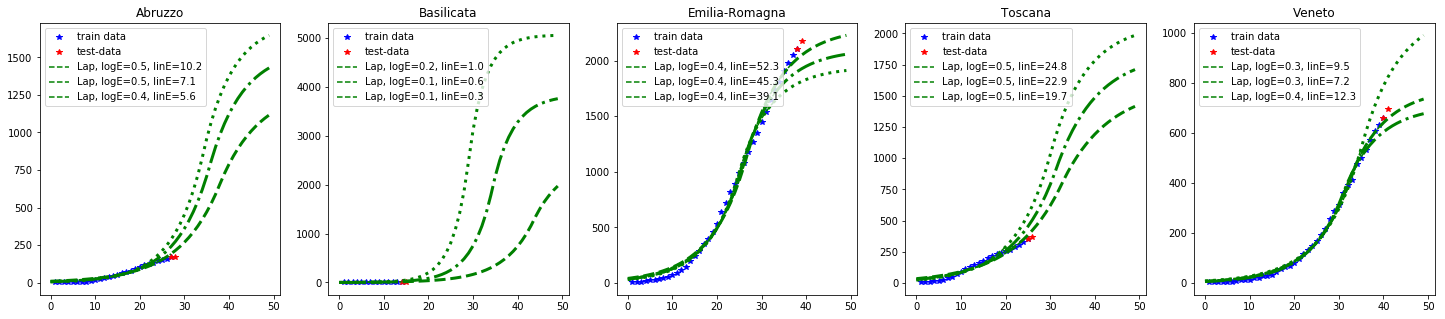

Abruzzo Gauss 200.68686694419515 0.13671725111390123 19.84652982335738
Abruzzo Gauss 204.0783656465819 0.13532082954092162 20.004470310167324
Abruzzo Gauss 188.09820014249192 0.14182140091055634 19.268707242191752
Basilicata Gauss 13.986091126650354 0.25264242223198646 7.983729097477356
Basilicata Gauss 16.237278182889504 0.22878798412985268 8.788784507611874
Basilicata Gauss 535.956722696323 0.10302667568430596 29.635166283828276
Emilia-Romagna Gauss 2433.181772144259 0.10301463613514619 27.480915848107017
Emilia-Romagna Gauss 2332.469944740158 0.10646730009246212 26.92272723732581
Emilia-Romagna Gauss 2226.9117418563064 0.11001835613054262 26.349836740688996
Toscana Gauss 363.6751883282219 0.13764052253302642 15.418167436684348
Toscana Gauss 300.200976669525 0.16902576425814586 13.481657539022125
Toscana Gauss 275.5782180647895 0.1854732750246763 12.738621933896468
Veneto Gauss 965.8793901667516 0.09421534136845604 34.64789225006254
Veneto Gauss 1107.2840347596718 0.08805833590015191

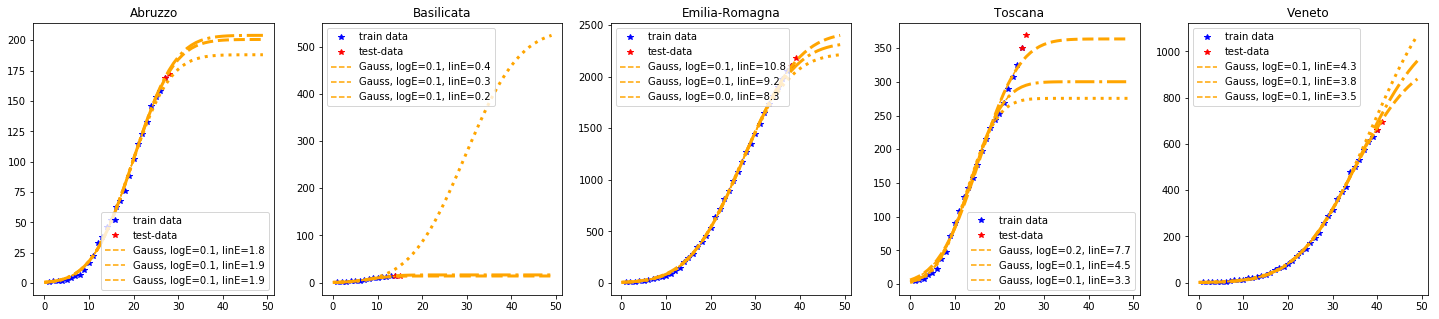

In [287]:
grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
errors = np.zeros((2, len(grp_names)))
log_errors =  np.zeros((2, len(grp_names)))
lap_params =  np.zeros((len(grp_names), 3))
gauss_params =  np.zeros((len(grp_names), 3))

test_offset = -1
i = 0

for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
    plt.figure(figsize=[25, 5])
    for j, grp in enumerate(grp_names):
        for test_offset, lss in zip([-1, -4, -6], ['--', '-.', ':']):
            group = dfg.get_group(grp).reset_index()
            group["death_rate"] = group["total_deaths"] / group['2018_population']
            yvec = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values
            x = np.arange(start, len(yvec)+test_offset)
            y = yvec[x]

            y_test = yvec[max(x):]
            x_test = np.arange(max(x), len(yvec))

            plt.subplot(1, 5, j+1)
            if test_offset==-1:
                plt.plot(x, y, 'b*', label='train data')
                plt.plot(x_test, y_test, 'r*', label='test-data')
            if len(y) > 4:
                popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
                y_fit =  model(x, *popt)
                log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
                errors[i, j] = np.mean(np.abs(y-y_fit))
                params[j, :] = np.asarray(popt)
                plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
                plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3.)
                print(grp, label, *popt)
            plt.legend()
            plt.title(grp)
        # plt.suptitle(label)
    plt.show()
    i += 1

### Stability to Initialization: Gaussian very stable

Abruzzo Lap [191.47465104444194, 0.5177001696081633, 0.6463876694979337] 163.59493109325004 0.17986119535754608 18.100855752309727
Abruzzo Lap [395.7826809595507, 0.2769923821921937, 0.30256408668073886] 163.59600861198257 0.17986040198954853 18.100918271300152
Abruzzo Lap [53.49919429963413, 0.2585928931503997, 0.0645717721513861] 163.5960181543681 0.17986038999510132 18.10091881214443
Basilicata Lap [399.0270257808678, 0.08825008946030666, 0.755029609816289] 292.02751142289975 0.24790950398497838 20.551309399918328
Basilicata Lap [360.4447701702911, 0.7080324128298718, 3.167780507386822] 126.88660767748283 0.2479098640833356 17.188969754326838
Basilicata Lap [354.3739480472876, 0.6847810232396448, 4.320626845467234] 144.91012751709448 0.24790945388466643 17.724737580482266


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Emilia-Romagna Lap [332.2056442808955, 0.304418062734521, 1.5760183061598532] 2017.3495137542252 0.13853288343312675 27.191011763175336
Emilia-Romagna Lap [25.337948983780834, 0.41324455903353163, 1.2741190608878905] 2017.350361163119 0.1385328266692604 27.191017716061822
Emilia-Romagna Lap [247.34446250204124, 0.5442521334710371, 0.12430397675931903] 2017.3462679723807 0.13853310553837062 27.190989010259482
Toscana Lap [155.32780277032714, 0.7473918833912091, 3.3549388620970584] 280.77066836811355 0.20919579755387988 15.911468711072214
Toscana Lap [94.41580485468648, 0.8083650571528715, 4.777834470869309] 280.771237110803 0.20919521561917748 15.911491689380327
Toscana Lap [191.68221739779295, 0.1945832429672426, 2.059322092054403] 280.7695111819417 0.20919697862704792 15.911421933569628
Veneto Lap [50.091808775052925, 0.9946094653806148, 3.349813960155592] 678.7440322297175 0.13628791329382092 32.43664166637057
Veneto Lap [195.08251629724006, 0.7656637690453131, 3.855822239599494] 678

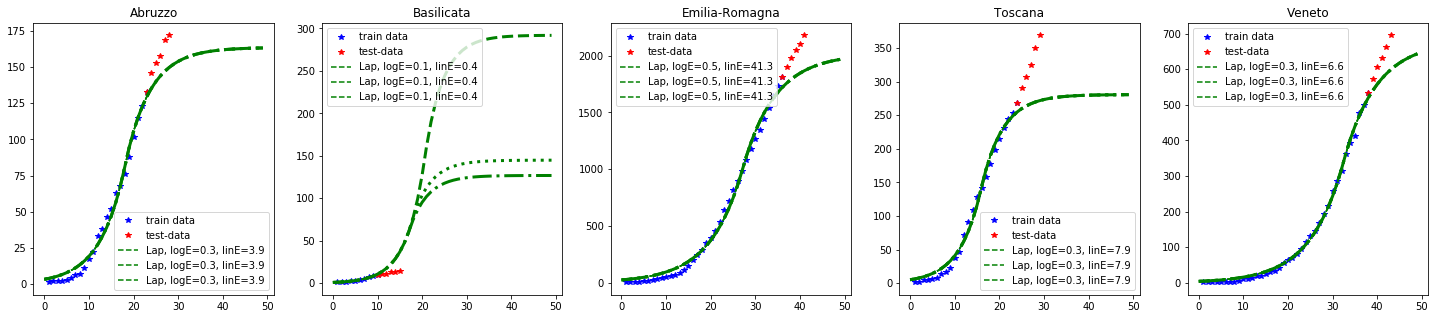

Abruzzo Gauss [230.23542873066455, 0.8513476929437568, 0.9066851461653386] 191.55900717585345 0.1403991889203318 19.427931503733248
Abruzzo Gauss [404.21346544319726, 0.5523385536902609, 3.940281311971532] 191.55860639978658 0.14039946270951137 19.427911135856668
Abruzzo Gauss [30.35354558730541, 0.20242173401117036, 2.3706893250291845] 191.55864229996632 0.14039944971202112 19.427912915378112
Basilicata Gauss [186.42985867660101, 0.3004565315156863, 3.5369644690111923] 24.090325933721658 0.18938445342322435 10.986946868916228
Basilicata Gauss [319.86474430687105, 0.042113628206679854, 1.7260637713147386] 24.090282196620286 0.1893845606813368 10.98693676313117
Basilicata Gauss [303.98421172261794, 0.9114828995132029, 0.9713062441266646] 24.090426297536933 0.18938408989405767 10.986971838422804
Emilia-Romagna Gauss [154.5086540514783, 0.8521050783963491, 2.829647880209011] 2274.5681186008437 0.10842435264353036 28.60724624507074
Emilia-Romagna Gauss [335.72706935795236, 0.73869779533198

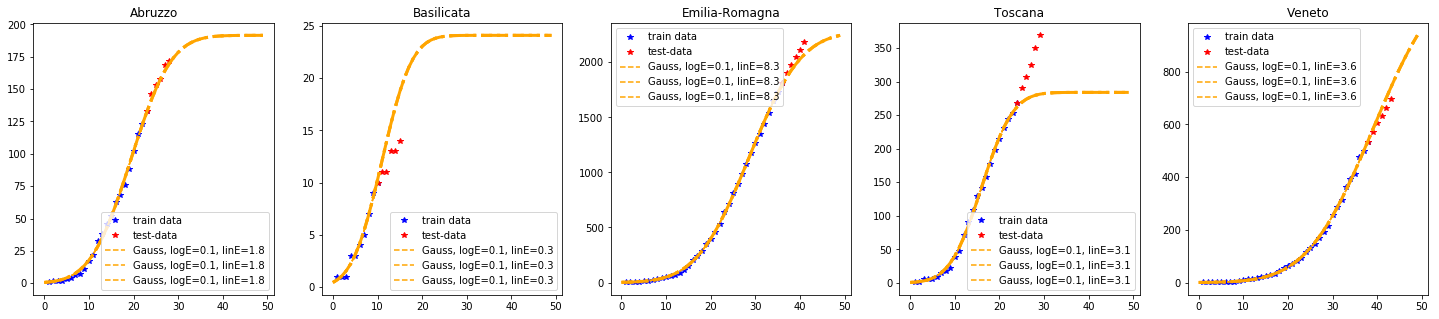

In [299]:
grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
errors = np.zeros((2, len(grp_names)))
log_errors =  np.zeros((2, len(grp_names)))
lap_params =  np.zeros((len(grp_names), 3))
gauss_params =  np.zeros((len(grp_names), 3))

test_offset = -5
i = 0

for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
    plt.figure(figsize=[25, 5])
    for j, grp in enumerate(grp_names):
        for lss in ['--', '-.', ':']:
            group = dfg.get_group(grp).reset_index()
            group["death_rate"] = group["total_deaths"] / group['2018_population']
            yvec = group[group["death_rate"]>np.exp(-18)]["total_deaths"].values
            x = np.arange(start, len(yvec)+test_offset)
            y = yvec[x]

            y_test = yvec[max(x):]
            x_test = np.arange(max(x), len(yvec))

            plt.subplot(1, 5, j+1)
            if lss=='--':
                plt.plot(x, y, 'b*', label='train data')
                plt.plot(x_test, y_test, 'r*', label='test-data')
            if len(y) > 4:
                p0 = [500*npr.rand(), npr.rand(), 5*npr.rand()]
                popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=p0, loss='linear')
                y_fit =  model(x, *popt)
                log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
                errors[i, j] = np.mean(np.abs(y-y_fit))
                params[j, :] = np.asarray(popt)
                plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
                plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3.)
                print(grp, label, p0, *popt)
            plt.legend()
            plt.title(grp)
        # plt.suptitle(label)
    plt.show()
    i += 1

### Stability to loss function

Abruzzo Lap [500, 0.5, 2.0] 163.59506189574896 0.1798610951576861 18.100863330961452
Abruzzo Lap [500, 0.5, 2.0] 1067.4029380580128 0.14140259963239898 31.853334536008678
Abruzzo Lap [500, 0.5, 2.0] 51.50191132300108 0.9993110388039759 99.87047550800513
Basilicata Lap [500, 0.5, 2.0] 187.28272059314216 0.2479093954635145 18.759415778895896
Basilicata Lap [500, 0.5, 2.0] 12.737046816891002 0.7554116407496885 99.92504251429077
Basilicata Lap [500, 0.5, 2.0] 51.5672607025416 0.9996401929799215 99.92882031727108


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Emilia-Romagna Lap [500, 0.5, 2.0] 2017.3473851757178 0.1385330276892018 27.190996826739205
Emilia-Romagna Lap [500, 0.5, 2.0] 1905.8293388992802 0.1455666032645303 26.4575304892058
Emilia-Romagna Lap [500, 0.5, 2.0] 898.6172402198042 0.9974927266210243 93.64106026620871
Toscana Lap [500, 0.5, 2.0] 280.77126360359085 0.20919518843526713 15.911492757953871
Toscana Lap [500, 0.5, 2.0] 1299.3580102292915 0.1233555428362745 29.80461248788847
Toscana Lap [500, 0.5, 2.0] 51.38448921194686 0.9987057699260318 99.76554374083769
Veneto Lap [500, 0.5, 2.0] 678.7434986775013 0.1362879789434762 32.436632481815714
Veneto Lap [500, 0.5, 2.0] 665.5458393941283 0.14096228876272934 32.06371877712792
Veneto Lap [500, 0.5, 2.0] 584.9333653491304 0.20525196560911388 29.67211850990583


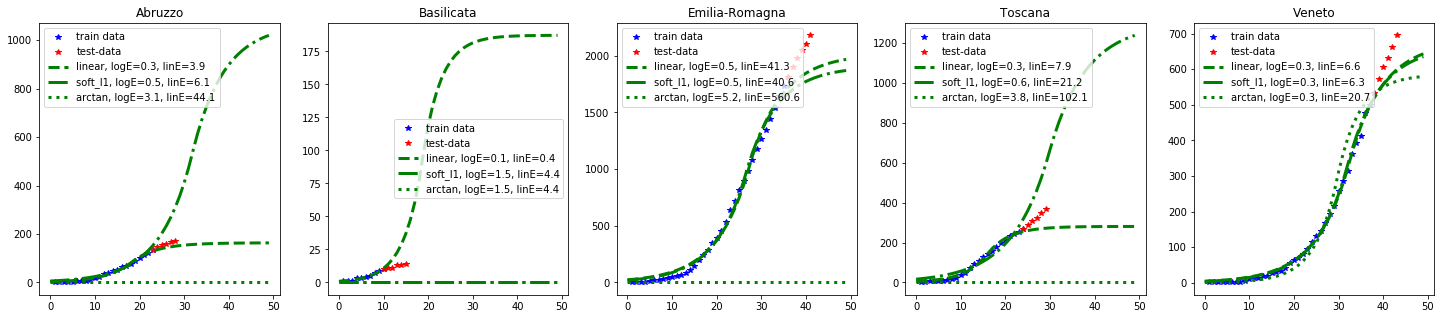

Abruzzo Gauss [500, 0.5, 2.0] 191.55889642556573 0.1403992690308259 19.427925857547457
Abruzzo Gauss [500, 0.5, 2.0] 183.99133610044703 0.14654424254798323 19.0118577988038
Abruzzo Gauss [500, 0.5, 2.0] 51.50813844542819 0.9994394581254249 99.8759399853125
Basilicata Gauss [500, 0.5, 2.0] 24.09040435168579 0.18938417750774816 10.986966257691769
Basilicata Gauss [500, 0.5, 2.0] 11.673969387395118 0.7899711262801172 99.81642048791079
Basilicata Gauss [500, 0.5, 2.0] 51.571860195157285 0.9997050008296071 99.93288352381748
Emilia-Romagna Gauss [500, 0.5, 2.0] 2274.5681074873937 0.10842435341721078 28.60724618122455
Emilia-Romagna Gauss [500, 0.5, 2.0] 2296.995813326015 0.10809822510260056 28.725065671580147
Emilia-Romagna Gauss [500, 0.5, 2.0] 986.9498514267923 0.23004751449519986 14.472043461127981
Toscana Gauss [500, 0.5, 2.0] 283.9545563426352 0.1795359520357969 15.988931912708718
Toscana Gauss [500, 0.5, 2.0] 283.9255294820531 0.18070694840061446 16.083599419677373
Toscana Gauss [500, 

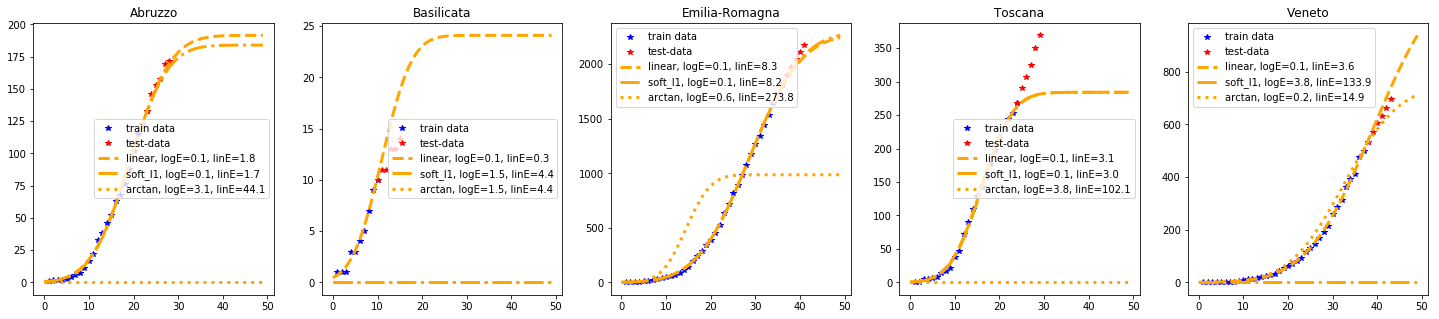

In [303]:
grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
errors = np.zeros((2, len(grp_names)))
log_errors =  np.zeros((2, len(grp_names)))
lap_params =  np.zeros((len(grp_names), 3))
gauss_params =  np.zeros((len(grp_names), 3))

test_offset = -5
i = 0

for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
    plt.figure(figsize=[25, 5])
    for j, grp in enumerate(grp_names):
        for loss, lss in zip(['linear', 'soft_l1', 'arctan'], ['--', '-.', ':']):
            group = dfg.get_group(grp).reset_index()
            group["death_rate"] = group["total_deaths"] / group['2018_population']
            yvec = group[group["death_rate"]>np.exp(-18)]["total_deaths"].values
            x = np.arange(start, len(yvec)+test_offset)
            y = yvec[x]

            y_test = yvec[max(x):]
            x_test = np.arange(max(x), len(yvec))

            plt.subplot(1, 5, j+1)
            if lss=='--':
                plt.plot(x, y, 'b*', label='train data')
                plt.plot(x_test, y_test, 'r*', label='test-data')
            if len(y) > 4:
                p0 = [500, 0.5, 2.]
                popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=p0, loss=loss)
                y_fit =  model(x, *popt)
                log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
                errors[i, j] = np.mean(np.abs(y-y_fit))
                params[j, :] = np.asarray(popt)
#                 plt.plot(x, y_fit, color=color, linestyle='--')
                plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3., label='%s, logE=%.1f, linE=%.1f' %(loss, log_errors[i, j], errors[i, j]))
                print(grp, label, p0, *popt)
            plt.legend()
            plt.title(grp)
        # plt.suptitle(label)
    plt.show()
    i += 1

## Exahusitive Comparison

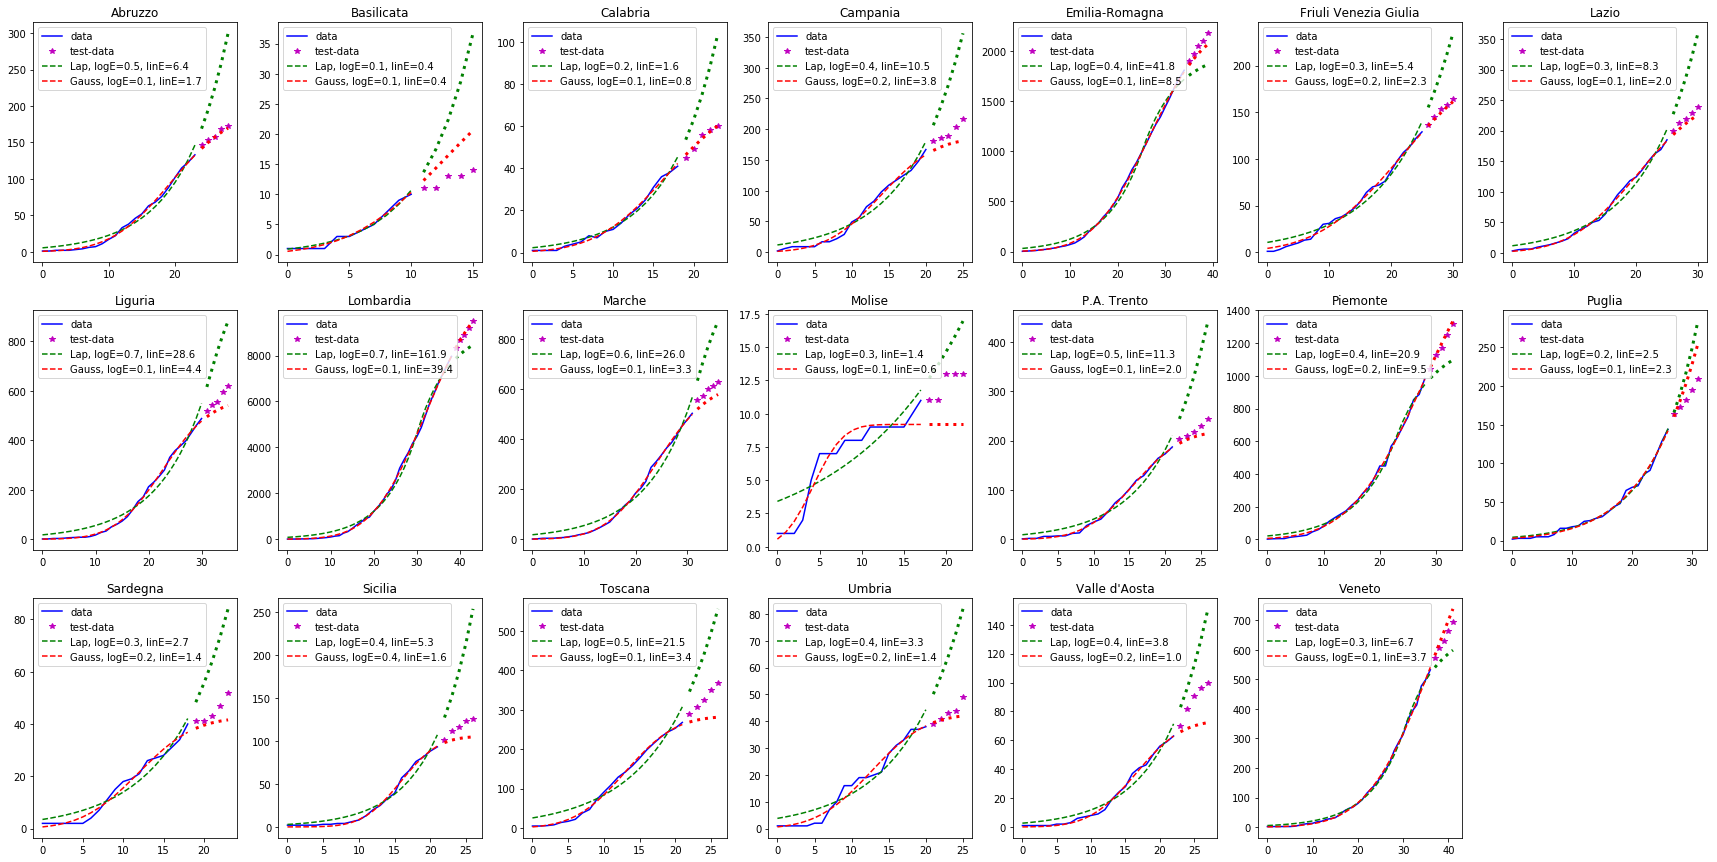

In [304]:
grp_names = dfg.groups.keys()
errors = np.zeros((2, len(grp_names)))
log_errors =  np.zeros((2, len(grp_names)))
lap_params =  np.zeros((len(grp_names), 3))
gauss_params =  np.zeros((len(grp_names), 3))

test_offset = -5
plt.figure(figsize=[30, 15])
for j, grp in enumerate(grp_names):
    group = dfg.get_group(grp).reset_index()
    group["death_rate"] = group["total_deaths"] / group['2018_population']
    y = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values[:test_offset]
    x = np.arange(len(y))
    
    y_test = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values[test_offset:]
    x_test = np.arange(len(x), len(x)+len(y_test))
    
    plt.subplot(3, 7, j+1)
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x_test, y_test, 'm*', label='test-data')
    if len(y) > 5:
        i = 0
        for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'red'],[lap_params, gauss_params]):
            popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
            y_fit =  model(x, *popt)
            log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
            errors[i, j] = np.mean(np.abs(y-y_fit))
            params[j, :] = np.asarray(popt)
            plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
            plt.plot(x_test, model(x_test, *popt), color=color, linestyle=':', linewidth=3.)
            i += 1
    plt.legend()
    plt.title(grp)
# plt.suptitle(label)
plt.show()

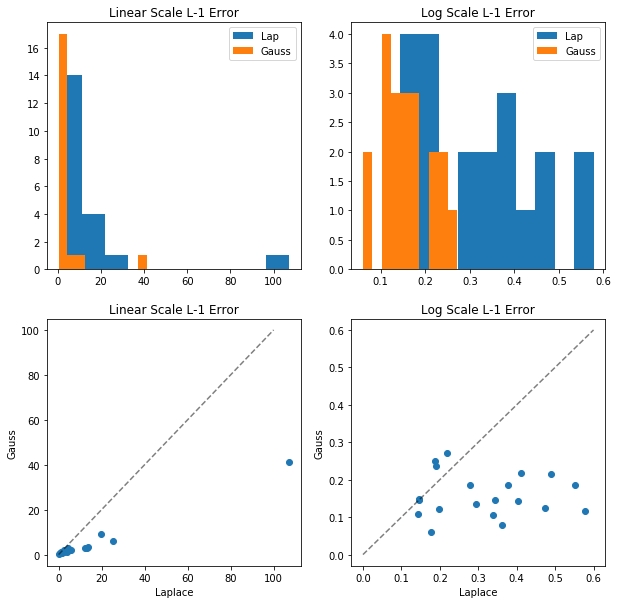

In [221]:
plt.figure(figsize=[10, 10])
plt.subplot(221)
plt.hist(errors[0, :], label='Lap')
plt.hist(errors[1, :], label='Gauss')
plt.legend()
plt.title('Linear Scale L-1 Error')
plt.subplot(222)
plt.hist(log_errors[0, :], label='Lap')
plt.hist(log_errors[1, :], label='Gauss')
plt.legend()
plt.title('Log Scale L-1 Error')
plt.subplot(223)
plt.scatter(errors[0, :], errors[1, :])
plt.plot([0, 100], [0, 100], 'k--', alpha=0.5)
plt.xlabel('Laplace')
plt.ylabel('Gauss')
plt.title('Linear Scale L-1 Error')
plt.subplot(224)
plt.scatter(log_errors[0, :], log_errors[1, :])
plt.plot([0, 0.6], [0, 0.6], 'k--', alpha=0.5)
plt.xlabel('Laplace')
plt.ylabel('Gauss')
plt.title('Log Scale L-1 Error')
plt.show()

In [405]:
!pwd

/home/ubuntu/covid-19-geographic-risk-prediction/modeling/IHME


[228.2568247] 0.026151680704925795
[-8574894.82276993] 0.03171174215700856
[-146470.96202561] 0.14462257779508358
[242.63975821] 0.14984014411607927
[-9696536.12522285] 0.1787882948115035
[72874.4197998] 0.133969561796482
[-0.00013528] 0.03507273747871065
[-5.83859038] 0.056137689600318064
[0.02719381] 0.019034836559166934
[-4.09580109e-05] 0.01630264186379715
[2.47895767] 0.044619025939987456
[-0.01786339] 0.03073687057824004


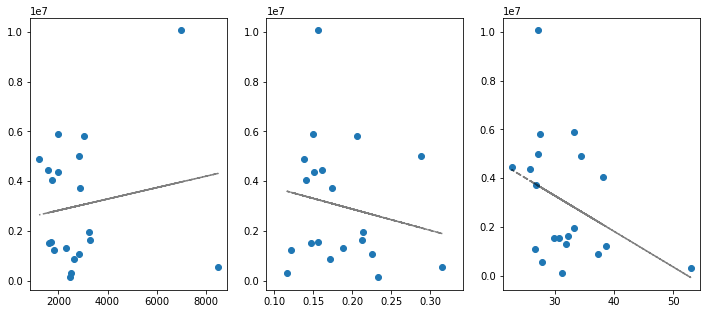

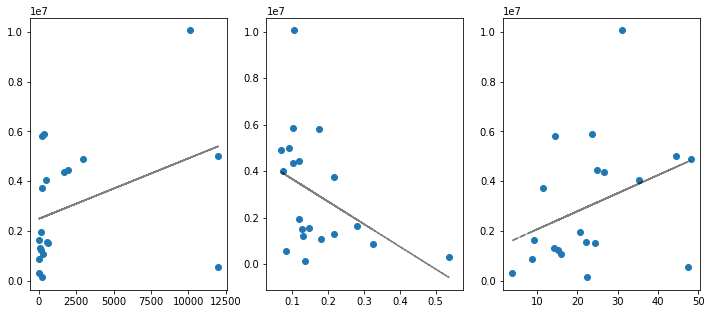

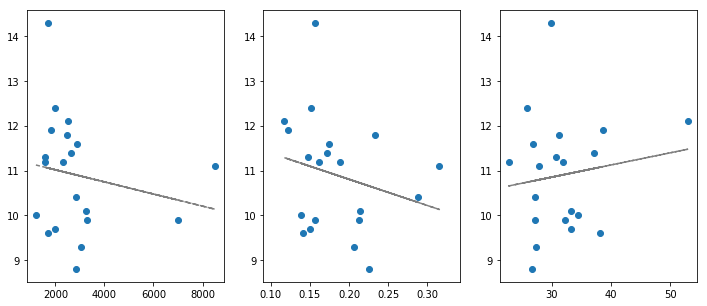

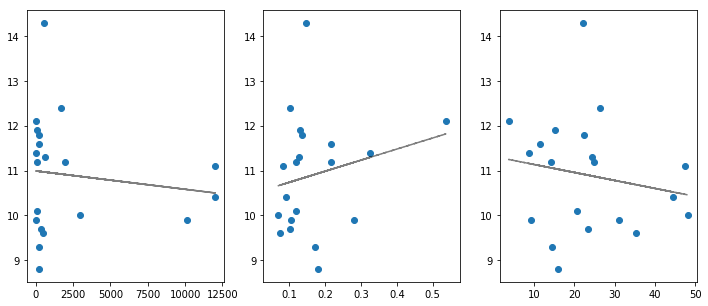

In [237]:
for field in ['2018_population', '2018_death_rate']:
    feat = np.zeros(lap_params.shape[0])
    for i, grp in enumerate(grp_names):
        group = dfg.get_group(grp).reset_index()
        feat[i] = group[field][0]

    for params in [lap_params, gauss_params]:
        plt.figure(figsize=[12, 5])
        for j in [0, 1, 2]:
            
            plt.subplot(1, 3, j+1)
            X = params[:,j].reshape(-1, 1)
            y = feat
            lm = LinearRegression()
            lm.fit(X, y)
            print(lm.coef_, lm.score(X, y))
            
            plt.scatter(X.flatten(), y)
            plt.plot(X.flatten(), lm.predict(X), 'k--', alpha=0.5)


Emilia-Romagna 40 11.2 0.0004888465620520074
Lombardia 44 9.9 0.0009426897511016766
Piemonte 34 12.4 0.00030277251477479374


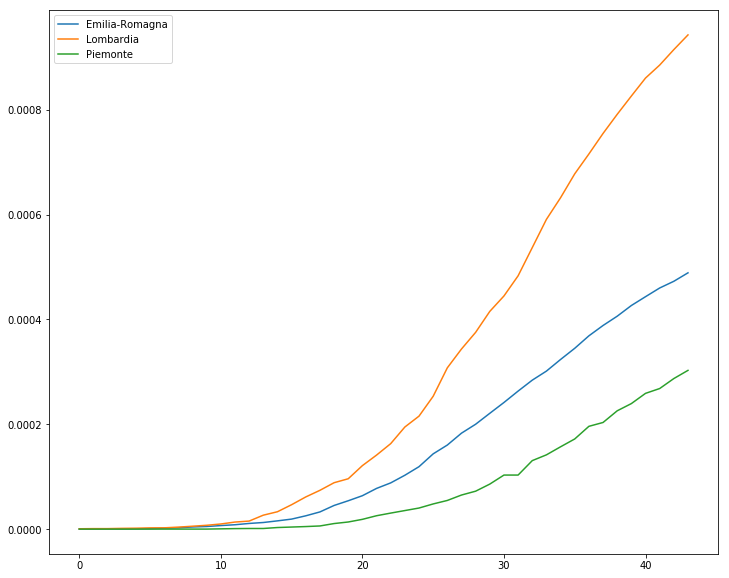

In [79]:
dfg = df.groupby('region_name')
plt.figure(figsize=[12, 10])
for name, group in dfg:
    group = group.reset_index()
    group["death_rate"] = group["total_deaths"] / group['2018_population']
#     print(name, np.asarray(group["hospitalized_with_symptoms"])[-1])
    if name  in ['Lombardia', 'Emilia-Romagna', 'Piemonte']:
        plt.plot(group["death_rate"], label=name)
        print(name, np.sum(group["death_rate"]> np.exp(-15.)), group["2018_death_rate"][0], 
              group["death_rate"][43])
plt.legend()
plt.show()

## Peak DifferenceM

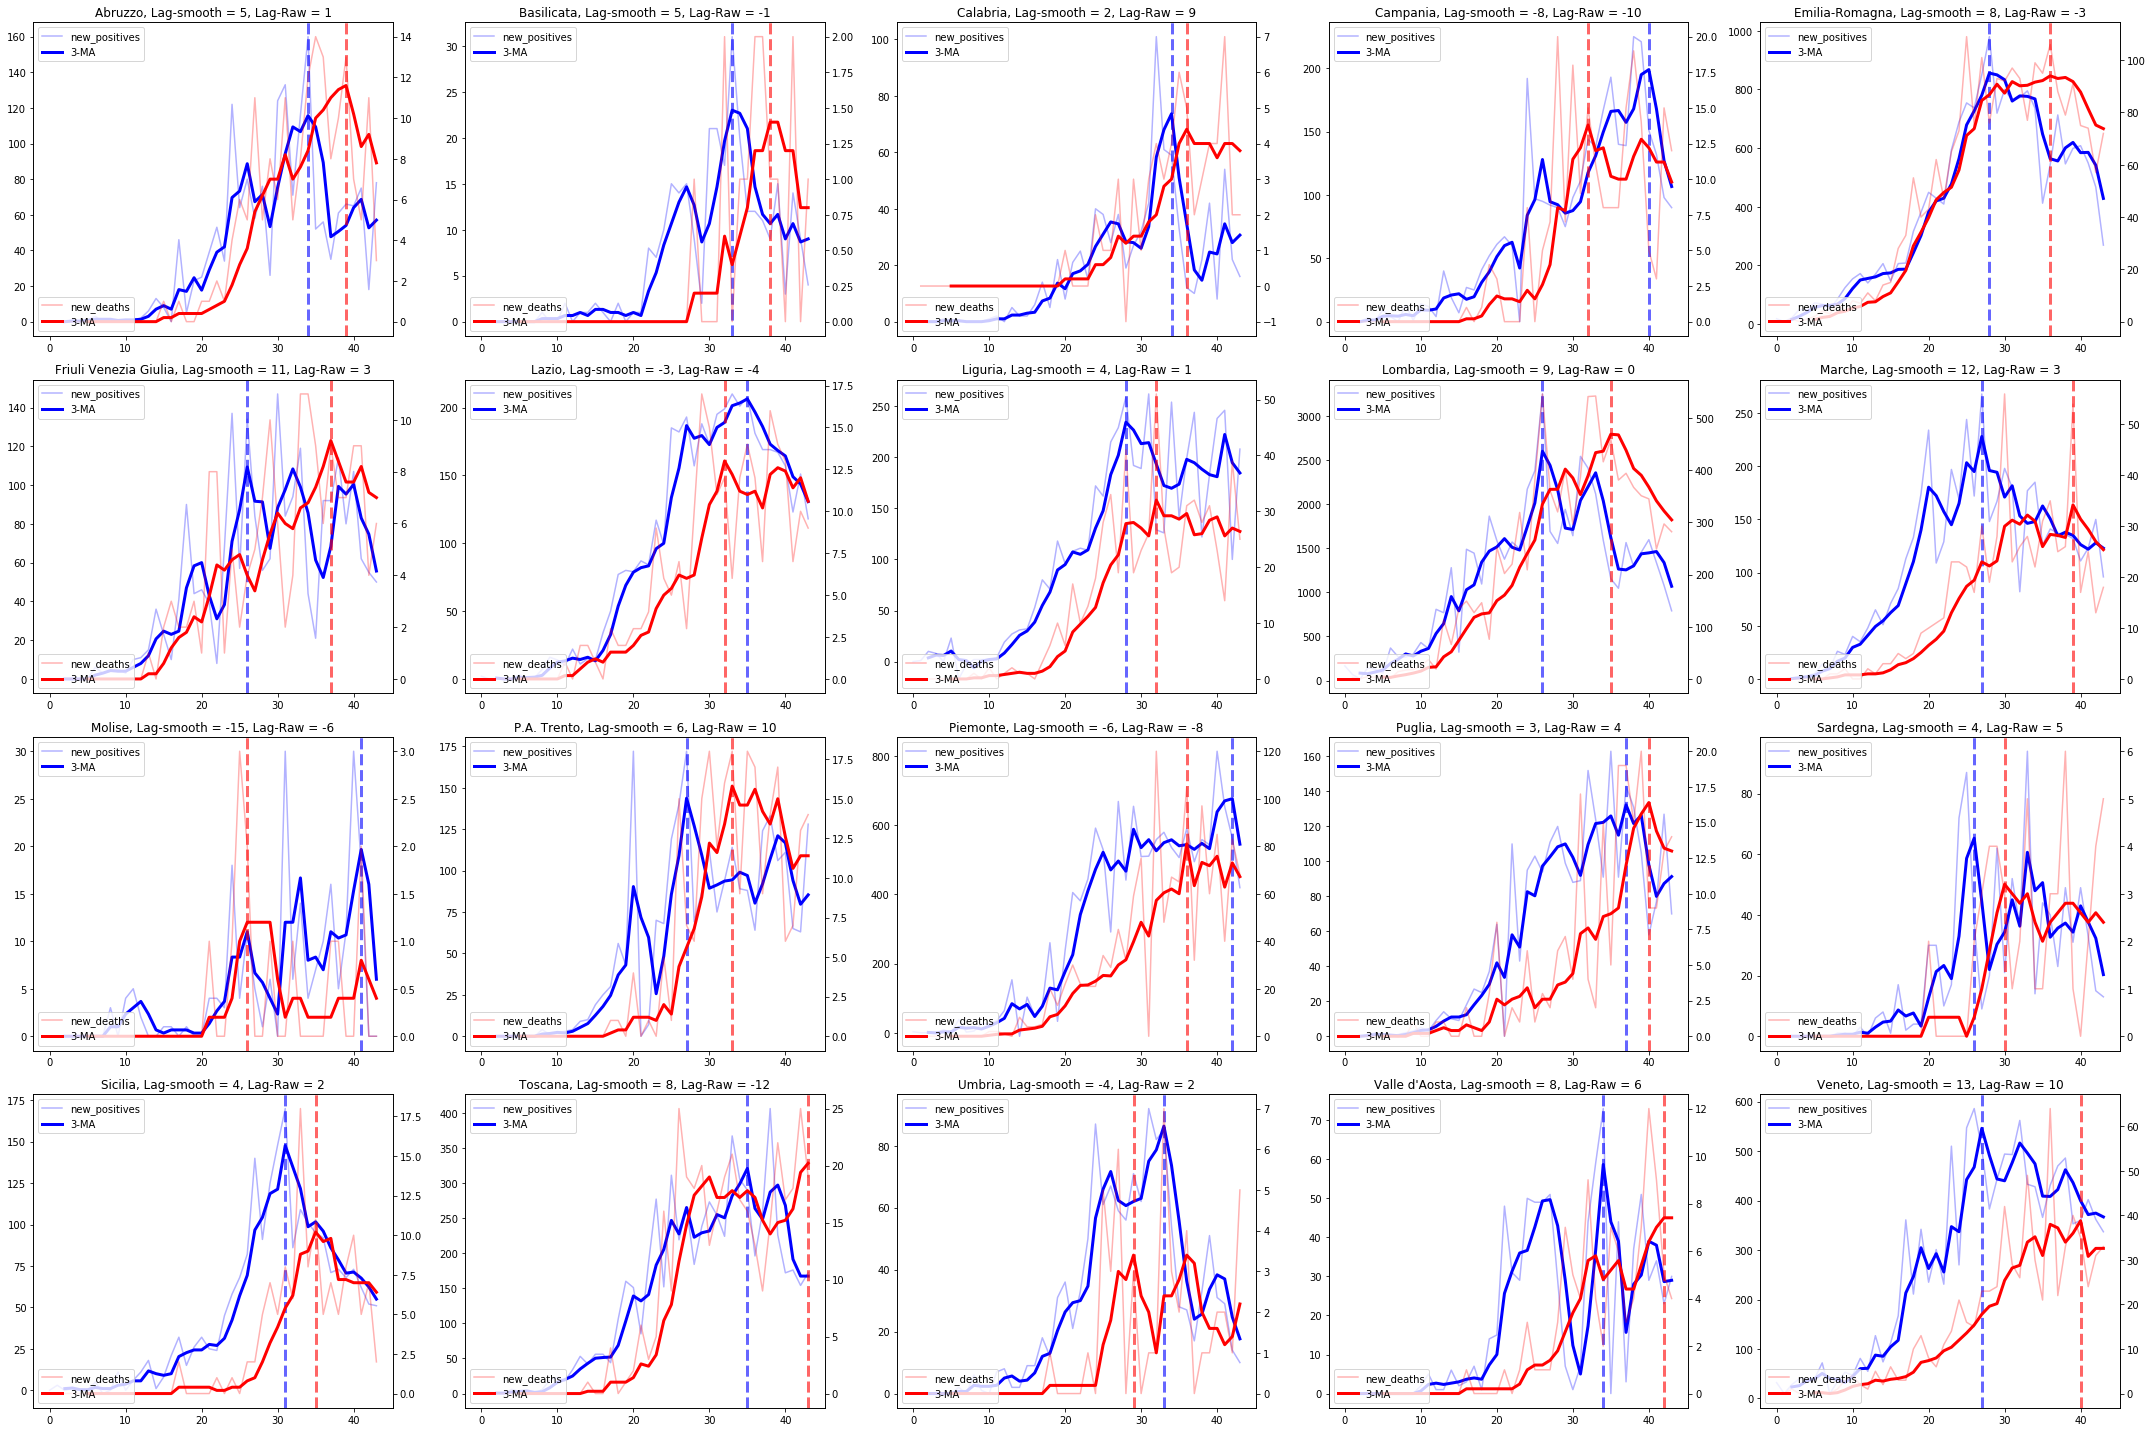

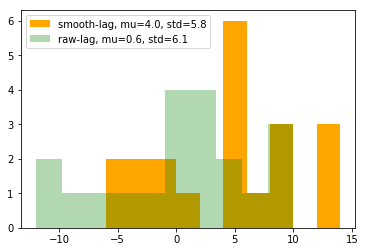

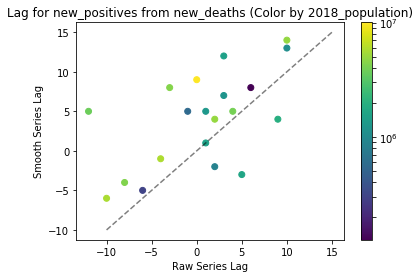

In [402]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
w = 3

f1, f2 = "new_positives", "new_deaths"
deltas = np.zeros(len(dfg.groups.keys()))
deltas_smooth = np.zeros(len(dfg.groups.keys()))
plt.figure(figsize=[30, 20])
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    group['new_deaths'] = group['total_deaths'] - group['total_deaths'].shift(1)
    group['new_hospitalized'] = group['total_hospitalized'] - group['total_hospitalized'].shift(1)
    group['new_intensive_care'] = group['intensive_care'] - group['intensive_care'].shift(1)
    group['new_home_isolation'] = group['home_isolation'] - group['home_isolation'].shift(1)
    
    y = group[f1]
    plt.plot(y, color='b', alpha=0.3)
    smooth_y =  y.rolling(window=w)
    smooth_y = smooth_y.mean()
    plt.plot(smooth_y, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y), np.argmax(smooth_y)
    plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    
    y = group[f2]
    ax.plot(y, color='r', alpha=0.3)
    smooth_y =  y.rolling(window=5)
    smooth_y = smooth_y.mean()
    ax.plot(smooth_y, color='r', linewidth=3., label='%d-MA'%w)
    x3, x4 = np.argmax(y), np.argmax(smooth_y)
    ax.axvline(x= x4, color='r', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='lower left')

    deltas_smooth[j] = x4-x1
    deltas[j] = x3-x1
    plt.title('%s, Lag-smooth = %d, Lag-Raw = %d'%(grp, x4-x2, x3-x1))
plt.tight_layout()
plt.show()

plt.hist(deltas_smooth, bins=10, color='orange', label='smooth-lag, mu=%.1f, std=%.1f'%(np.mean(deltas_smooth), np.std(deltas_smooth)))
plt.hist(deltas, bins=10, alpha=0.3,  color='g', label='raw-lag, mu=%.1f, std=%.1f'%(np.mean(deltas), np.std(deltas)))
plt.legend()
plt.show()

feat = np.zeros(len(dfg.groups.keys()))
f3 = '2018_population'
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    feat[j] = group[f3].tail(1).values[0]
# feat = np.log(1+feat)
# feat /= max(feat)
plt.scatter(deltas, deltas_smooth,  c=feat, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot([-10, 15], [-10, 15], 'k--', alpha=0.5)
plt.title('Lag for %s from %s (Color by %s)'%(f1, f2, f3))
plt.xlabel('Raw Series Lag')
plt.ylabel('Smooth Series Lag')
plt.show()

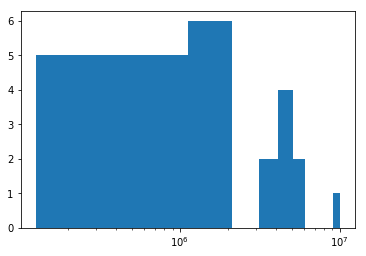

In [404]:
plt.hist(feat)
plt.xscale('log')

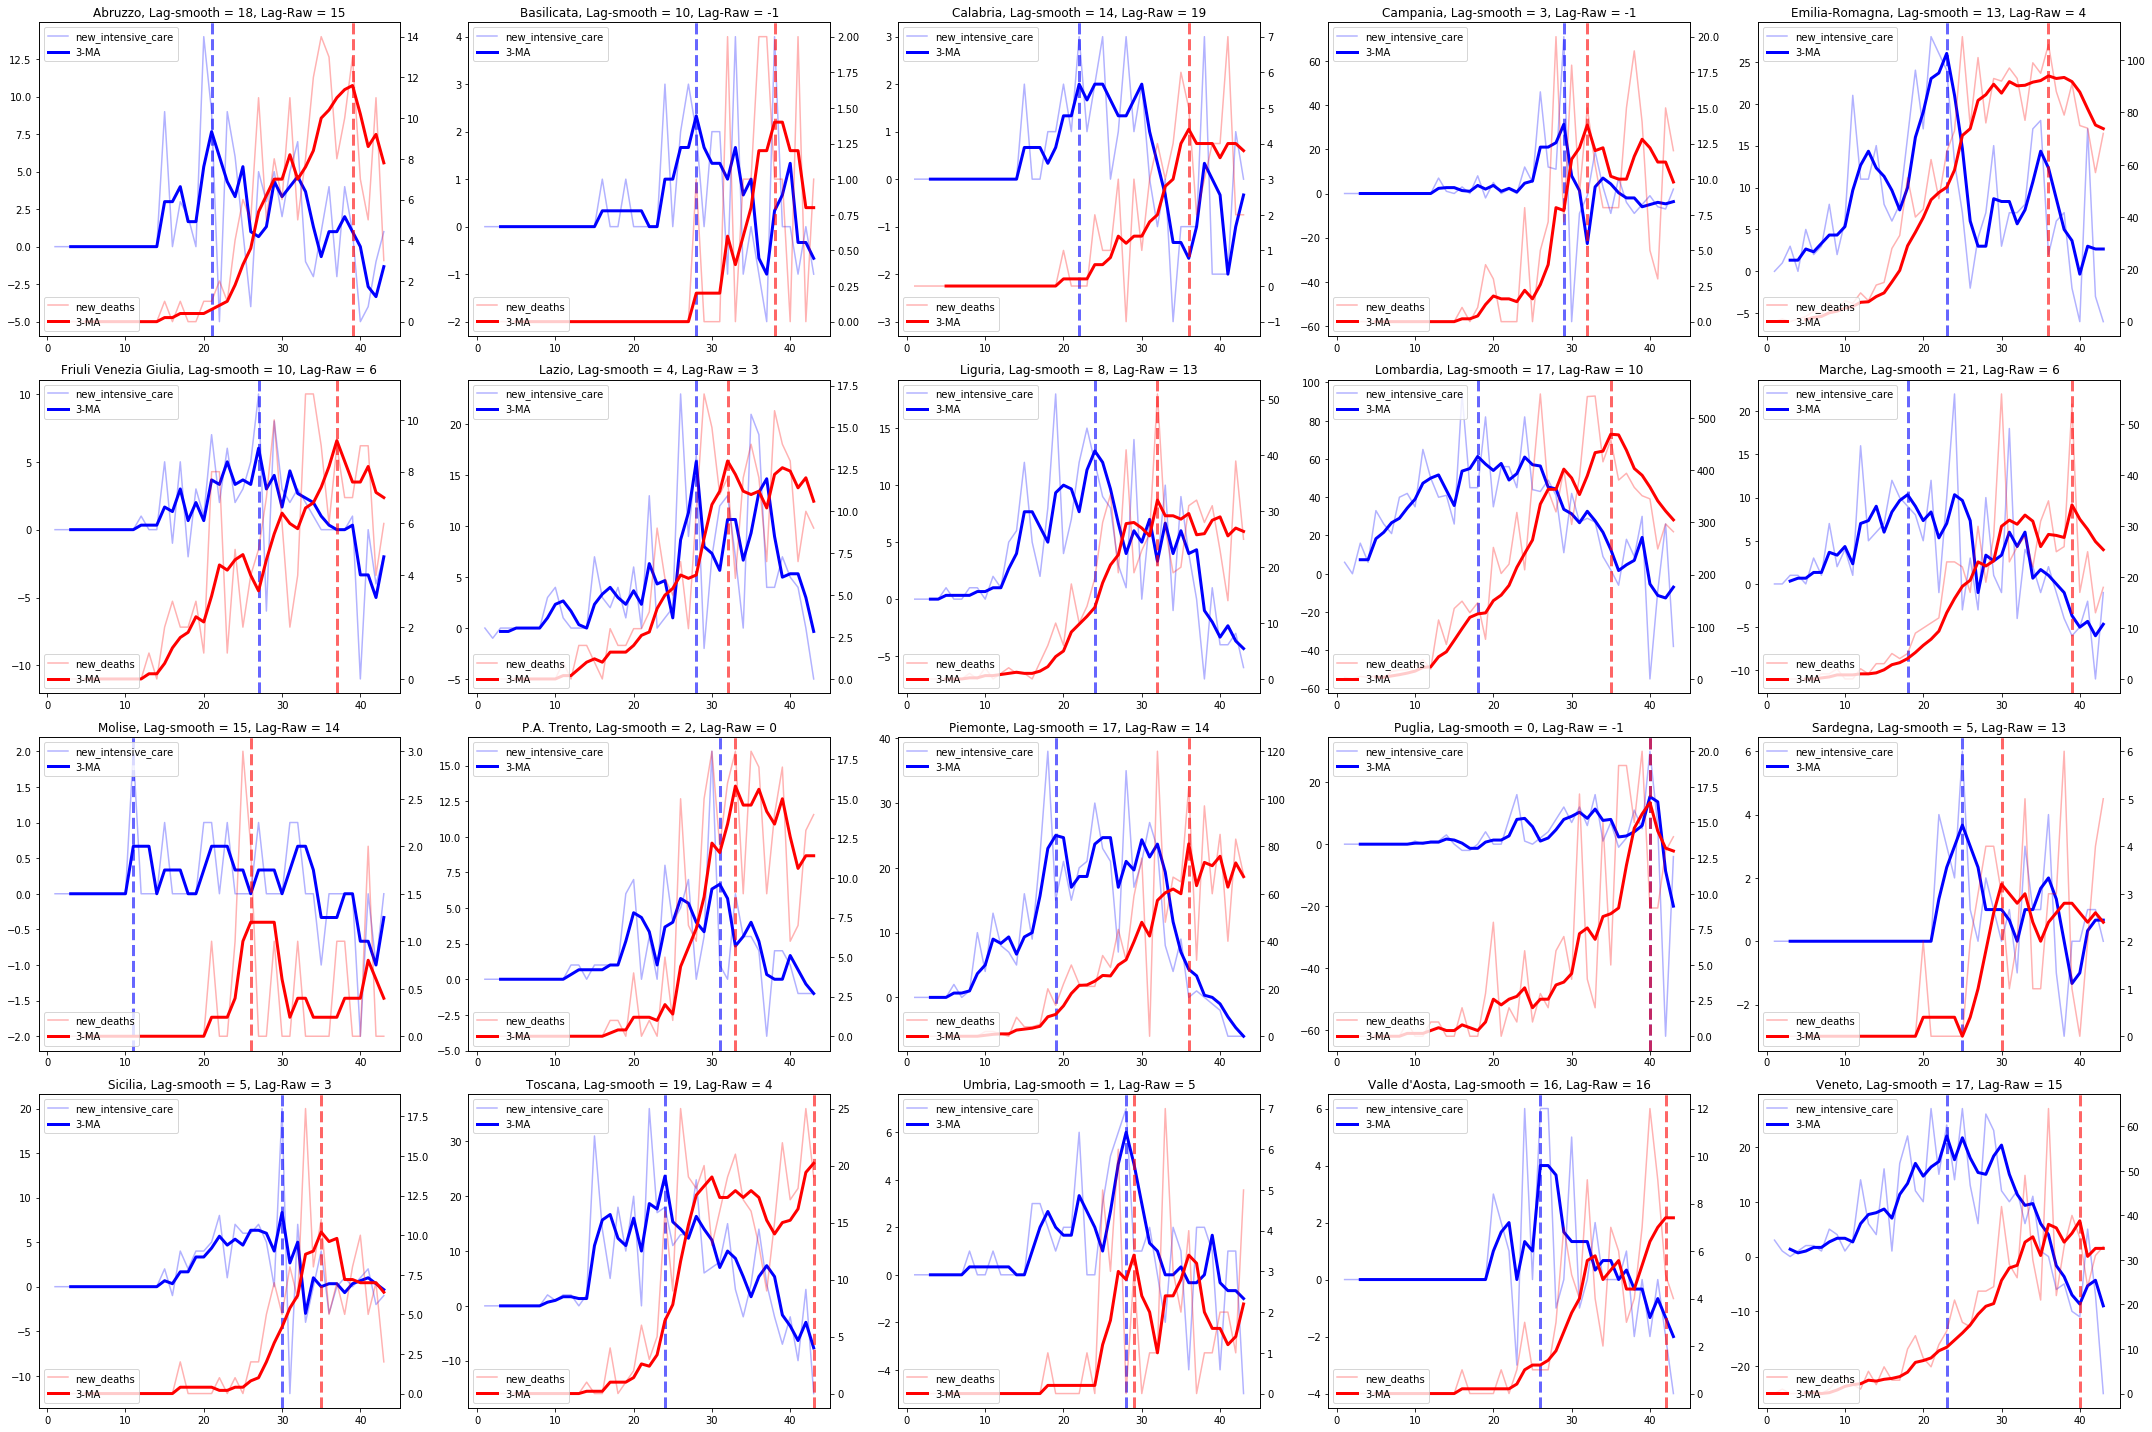

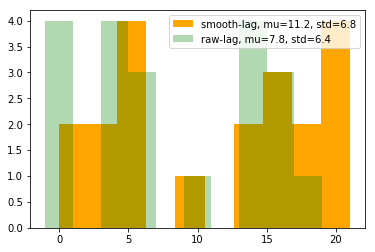

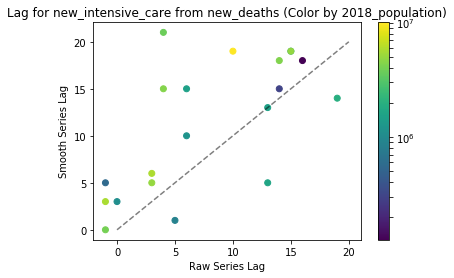

In [400]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
w = 3

f1, f2 = "new_intensive_care", "new_deaths"
deltas = np.zeros(len(dfg.groups.keys()))
deltas_smooth = np.zeros(len(dfg.groups.keys()))
plt.figure(figsize=[30, 20])
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    group['new_deaths'] = group['total_deaths'] - group['total_deaths'].shift(1)
    group['new_hospitalized'] = group['total_hospitalized'] - group['total_hospitalized'].shift(1)
    group['new_intensive_care'] = group['intensive_care'] - group['intensive_care'].shift(1)
    group['new_home_isolation'] = group['home_isolation'] - group['home_isolation'].shift(1)
    
    y = group[f1]
    plt.plot(y, color='b', alpha=0.3)
    smooth_y =  y.rolling(window=w)
    smooth_y = smooth_y.mean()
    plt.plot(smooth_y, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y), np.argmax(smooth_y)
    plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    
    y = group[f2]
    ax.plot(y, color='r', alpha=0.3)
    smooth_y =  y.rolling(window=5)
    smooth_y = smooth_y.mean()
    ax.plot(smooth_y, color='r', linewidth=3., label='%d-MA'%w)
    x3, x4 = np.argmax(y), np.argmax(smooth_y)
    ax.axvline(x= x4, color='r', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='lower left')

    deltas_smooth[j] = x4-x1
    deltas[j] = x3-x1
    plt.title('%s, Lag-smooth = %d, Lag-Raw = %d'%(grp, x4-x2, x3-x1))
plt.tight_layout()
plt.show()

plt.hist(deltas_smooth, bins=10, color='orange', label='smooth-lag, mu=%.1f, std=%.1f'%(np.mean(deltas_smooth), np.std(deltas_smooth)))
plt.hist(deltas, bins=10, alpha=0.3,  color='g', label='raw-lag, mu=%.1f, std=%.1f'%(np.mean(deltas), np.std(deltas)))
plt.legend()
plt.show()

feat = np.zeros(len(dfg.groups.keys()))
f3 = '2018_population'
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    feat[j] = group[f3].tail(1).values[0]
# feat = np.log(1+feat)
# feat /= max(feat)
plt.scatter(deltas, deltas_smooth,  c=feat, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot([0, 20], [0, 20], 'k--', alpha=0.5)
plt.title('Lag for %s from %s (Color by %s)'%(f1, f2, f3))
plt.xlabel('Raw Series Lag')
plt.ylabel('Smooth Series Lag')
plt.show()

In [395]:
cmap = matplotlib.cm.get_cmap('viridis')

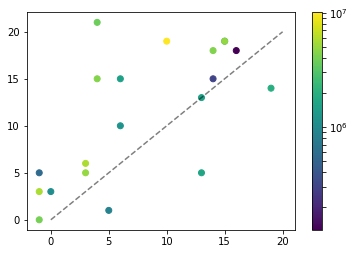

In [359]:
group[['hospitalized_with_symptoms', 'intensive_care', 'total_hospitalized',
       'home_isolation', 'total_positive', 'total_positive_change',
       'new_positives', 'discharged_healed', 'total_deaths', 'total_cases',
       'swabs',]][10:15]

,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_isolation,total_positive,total_positive_change,new_positives,discharged_healed,total_deaths,total_cases,swabs
10,92.0,24.0,116.0,264.0,380.0,35.0,47.0,17.0,10.0,407.0,11949.0
11,117.0,27.0,144.0,310.0,454.0,74.0,81.0,22.0,12.0,488.0,13023.0
12,123.0,41.0,164.0,341.0,505.0,51.0,55.0,25.0,13.0,543.0,14429.0
13,146.0,47.0,193.0,430.0,623.0,118.0,127.0,29.0,18.0,670.0,15918.0
14,186.0,51.0,237.0,457.0,694.0,71.0,74.0,30.0,20.0,744.0,15956.0


In [398]:
group.keys()

Index(['index', 'date', 'state', 'region_code', 'region_name', 'lat', 'long',
       'hospitalized_with_symptoms', 'intensive_care', 'total_hospitalized',
       'home_isolation', 'total_positive', 'total_positive_change',
       'new_positives', 'discharged_healed', 'total_deaths', 'total_cases',
       'swabs', 'note_it', 'note_en', 'region_english', '2018_death_rate',
       '2018_deaths', '2018_population'],
      dtype='object')

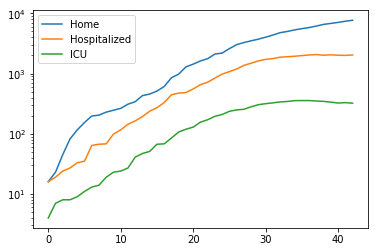

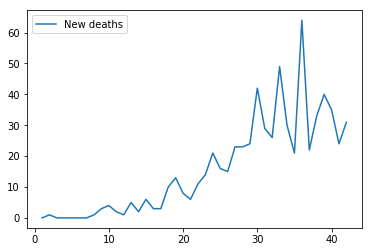

In [124]:
plt.plot(group["home_isolation"], label='Home')
plt.plot(group["total_hospitalized"], label='Hospitalized')
plt.plot(group["intensive_care"], label='ICU')
plt.yscale('log')
plt.legend()
plt.show()


# plt.plot(group["total_positive_change"], label='New cases')
plt.plot(group["new_deaths"], label='New deaths')
# plt.plot(group["intensive_care"], label='ICU')
# plt.yscale('log')
plt.legend()
plt.show()


In [125]:
from scipy.stats import norm as normal
from scipy.stats import laplace as laplace

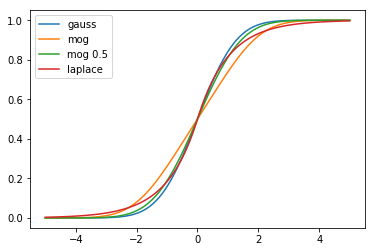

In [133]:
xx = np.linspace(-5., 5, 100)
plt.plot(xx, normal.cdf(xx), label='gauss')
plt.plot(xx, 0.5*(normal.cdf(xx, loc=1.)+normal.cdf(xx, loc=-1.)), label='mog')
plt.plot(xx, 0.5*(normal.cdf(xx, loc=.5)+normal.cdf(xx, loc=-.5)), label='mog 0.5')
plt.plot(xx, laplace.cdf(xx), label='laplace')
plt.legend()
plt.show()
# plt.plot(xx, normal.pdf(xx))

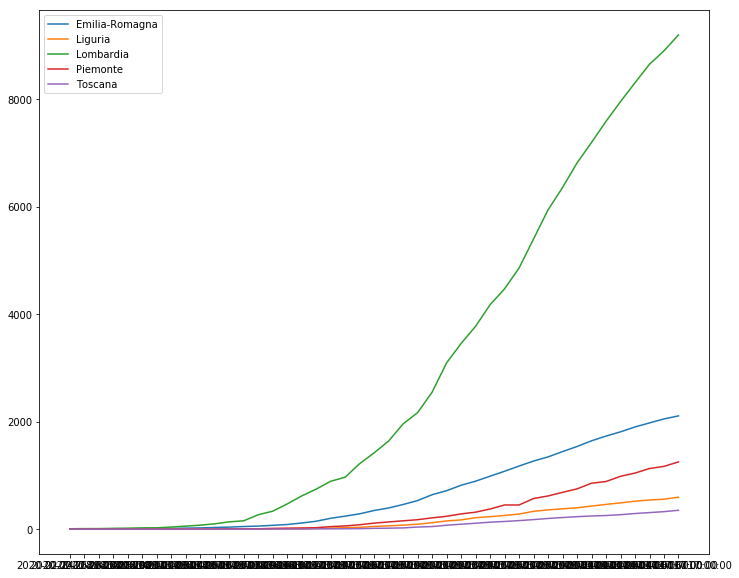

In [134]:
dfg = df.groupby('region_name')
plt.figure(figsize=[12, 10])
for name, group in dfg:
    group = group.reset_index()
#     group.reset_index()['deceased'].shift(0) - group.reset_index()['deceased'].shift(1)
    group['new_deaths'] = group['total_deaths'] - group['total_deaths'].shift(1)

#     print(name, np.asarray(group["hospitalized_with_symptoms"])[-1])
    if name in ['Emilia-Romagna','Liguria', 'Lombardia', 'Piemonte', 'Toscana']:
        plt.plot(group.date, group["total_deaths"], label=name)
plt.legend()
plt.show()

In [135]:
df.region_name.unique()

array(['Abruzzo', 'Basilicata', 'P.A. Bolzano', 'Calabria', 'Campania',
       'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria',
       'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna',
       'Sicilia', 'Toscana', 'P.A. Trento', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)